# Score dropped from 13.50678 to 13.03042

Nice!

### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Plotting helper function

In [2]:
def pretty_bar(data, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(15,12))
    sns.barplot(data.values, data.index)
    for i, v in enumerate(data.values):
        plt.text(0.8,i,v,color='k',fontsize=19)
    ylabel != None and plt.ylabel(ylabel, fontsize=12)
    xlabel != None and plt.xlabel(xlabel, fontsize=12)
    title != None and plt.title(title, fontsize=16)
    plt.show()

### Load data

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

train = pd.read_csv("../../data/shelter/train.csv", parse_dates=['DateTime'], date_parser=dateparse)
test  = pd.read_csv("../../data/shelter/test.csv", parse_dates=['DateTime'], date_parser=dateparse)

print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (26729, 10)
test shape: (11456, 8)


### First few rows of the train data

- I wonder why the name is included?  Is there anything we can do with it?  I don't think so, but missing names might indicate something (going off 5 data points, NaN is correlated with transfers)

- What use can I make out of OutcomeSubtype?  I wonder if the model would learn the subtypes easier, then I could map those to the OutcomeType

In [4]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### First few rows of the test data

In [5]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### Missing data

In [6]:
pd.DataFrame({
    "Train Missing": train.isnull().sum().astype(int),
    "Test Missing": test.isnull().sum().astype(int),
})

,Test Missing,Train Missing
AgeuponOutcome,6.0,18.0
AnimalID,NaN,0.0
AnimalType,0.0,0.0
Breed,0.0,0.0
Color,0.0,0.0
DateTime,0.0,0.0
ID,0.0,NaN
Name,3225.0,7691.0
OutcomeSubtype,NaN,13612.0
OutcomeType,NaN,0.0


### Is it possible to guess the Sex?

Not really, you can't guess a sex and whether a pet is neutered.  Since there's one missing value it doesn't make since to replace all NaN values with None.

I'm just going to drop this as an outlier

In [7]:
train[train.SexuponOutcome.isnull()]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle


In [8]:
train = train.drop(train[train.SexuponOutcome.isnull()].index)

### Merge train and test data

In [9]:
full = pd.concat([train, test])
train_N = len(train)

### Create columns sex and is_netured

In [10]:
def get_neut(x):
    if x is np.nan:
        return np.nan
    elif x == "Unknown":
        return 2
    return int("Neutered" in x or "Sprayed" in x)

def get_sex(x):
    if x is np.nan:
        return np.nan
    elif x == "Unknown":
        return 2
    return int("Male" in x)

full["Sex"] = full.SexuponOutcome.map(get_sex)
full["isNetured"] = full.SexuponOutcome.map(get_neut)

full = full.drop(["SexuponOutcome"], axis=1)

### AgeuponOutcome

In [11]:
def format_age(x):
    if x is np.nan:
        return None
    
    num, scale = x.split(" ")
    if scale in ["day", "days"]:
        return int(num)
    elif scale in ["week", "weeks"]:
        return 7 * int(num)
    elif scale in ["month", "months"]:
        return 30 * int(num)
    elif scale in ["year", "years"]:
        return 365 * int(num)
    else:
        print("scale", scale)
        raise Exception("Scale, {}, not contained".format(scale))

full.AgeuponOutcome = full.AgeuponOutcome.map(format_age)

### Fill in AgeuponOutcome values

In [12]:
full.AgeuponOutcome.fillna(
    full.groupby("Breed")["AgeuponOutcome"].transform("median"), inplace=True)

### AnimalType mapping

In [13]:
animal_map = {"Dog": 0, "Cat": 1}

full.AnimalType = full.AnimalType.map(animal_map)

## Breed

### isMix

Looks at the breed and determines whether the breed is a mix

In [14]:
shorthair_map  = lambda x: 1 if "Shorthair" in x else 0
mediumhair_map = lambda x: 1 if "Medium Hair" in x else 0
longhair_map   = lambda x: 1 if "Longhair" in x else 0
mix_map        = lambda x: 1 if "Mix" in x else 0

full["Shorthair"]  = full.Breed.map(shorthair_map)
full["Mediumhair"] = full.Breed.map(mediumhair_map)
full["Longhair"]   = full.Breed.map(longhair_map)
full["Mix"]        = full.Breed.map(mix_map)

### Plotting new columns

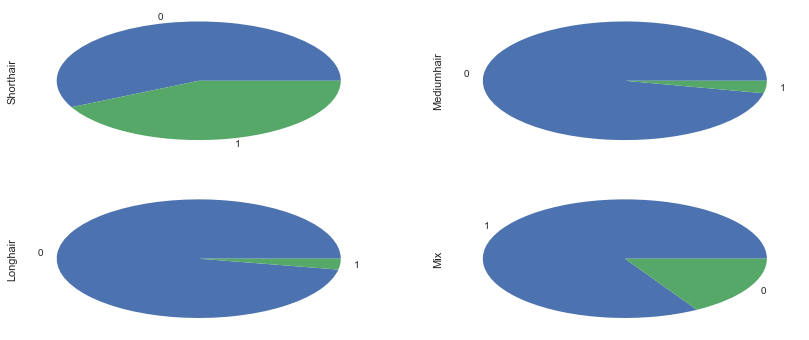

In [16]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 6))

full.Shorthair.value_counts().plot(kind="pie", ax=axarr[0][0])
full.Mediumhair.value_counts().plot(kind="pie", ax=axarr[0][1])
full.Longhair.value_counts().plot(kind="pie", ax=axarr[1][0])
_ = full.Mix.value_counts().plot(kind="pie", ax=axarr[1][1])

### Breed mapping

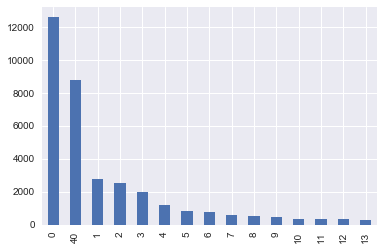

In [17]:
def get_col_map(df, col, cutoff):
    val_counts = df[col].value_counts()
    ret = dict()
    counter = 0
    
    for index in val_counts.index:
        count = val_counts[index]
        if count > cutoff:
            ret[index] = counter
            counter += 1
        else:
            ret[index] = counter
    return ret

breed_map = get_col_map(full, "Breed", 100)

full.Breed = full.Breed.map(breed_map)

_ = full.Breed.value_counts().head(15).plot(kind="bar")

### Color mapping

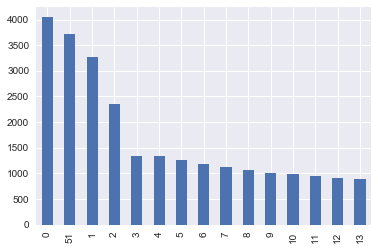

In [18]:
color_map = get_col_map(full, "Color", 100)

full.Color = full.Color.map(color_map)

_ = full.Color.value_counts().head(15).plot(kind="bar")

### Name

I'm wondering if a missing name is indicative of anything?  Maybe the name is missing because the dog was transfered quickly or spent a little time at the shelter.  Also some outcome's may rely on having documentation of the name

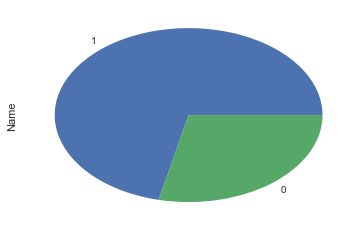

In [20]:
name_map = lambda x: 0 if x is np.nan else 1

full.Name = full.Name.map(name_map)
_ = full.Name.value_counts().plot(kind="pie")

### Split full back into train and test

In [21]:
train = full[:train_N]
test = full[train_N:]

### Quick prediction

In [22]:
train_y = train.OutcomeType
train_x = train.drop(["DateTime", "OutcomeType", "OutcomeSubtype", "AnimalID", "ID"], axis=1)

test_x = test.drop(["DateTime", "OutcomeType", "OutcomeSubtype", "AnimalID", "ID"], axis=1)

### Looking at the preprocessed data

In [23]:
train_x.head()

,AgeuponOutcome,AnimalType,Breed,Color,Name,Sex,isNetured,Shorthair,Mediumhair,Longhair,Mix
0,365.0,0,40,5,1,1,1,0,0,0,1
1,365.0,1,0,30,1,0,0,1,0,0,1
2,730.0,0,1,9,1,1,1,0,0,0,1
3,21.0,1,0,51,0,1,0,1,0,0,1
4,730.0,0,40,12,0,1,1,0,0,0,0


In [24]:
test_x.head()

,AgeuponOutcome,AnimalType,Breed,Color,Name,Sex,isNetured,Shorthair,Mediumhair,Longhair,Mix
0,300.0,0,3,25,1,0,0,0,0,0,1
1,730.0,0,40,10,1,0,0,0,0,0,0
2,365.0,1,0,2,1,1,1,1,0,0,1
3,120.0,0,40,8,1,1,0,0,0,0,1
4,730.0,0,10,3,1,1,1,0,0,0,1


## Construct the model

Let's try out a few models and see which works best through cross validation

In [25]:
# Different models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Cross validation imports
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold()

def score_model(model):
    score = cross_val_score(model, train_x, train_y, cv=k_fold, n_jobs=1, scoring="accuracy")
    print(score)
    print("\nAverage is ...")
    print(sum(score) / len(score))

### XGB (13.72084)

In [26]:
xgb_model = XGBClassifier()
xgb_model.fit(train_x, train_y)
score_model(xgb_model)

[ 0.61851852  0.60635313  0.61207767]

Average is ...
0.612316439611


### SVC (LB score: 15.44838)

In [27]:
svc_model = SVC()
svc_model.fit(train_x, train_y)
score_model(svc_model)

[ 0.54320988  0.54495454  0.54226064]

Average is ...
0.543475017403


### LGBM (LB score: 13.50678)

In [28]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(train_x, train_y)
score_model(lgbm_model)

[ 0.62031425  0.61364912  0.61566955]

Average is ...
0.616544306722


### Predictions

In [29]:
predictions = lgbm_model.predict(test_x)

### Save predictions to CSV

In [30]:
pd.DataFrame({
    "ID": test.ID.astype(int),
    "Adoption": [1 if pred == "Adoption" else 0 for pred in predictions],
    "Died": [1 if pred == "Died" else 0 for pred in predictions],
    "Euthanasia": [1 if pred == "Euthanasia" else 0 for pred in predictions],
    "Return_to_owner": [1 if pred == "Return_to_owner" else 0 for pred in predictions],
    "Transfer": [1 if pred == "Transfer" else 0 for pred in predictions]
}).to_csv('../../submissions/shelter_lgbm_more_cols.csv',index=False)